In [1]:
import numpy as np
from pylab import *
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits as fits
from astropy.wcs import WCS
from astropy.table import Table
from scipy.interpolate import griddata
from photutils.aperture import *
from scipy.ndimage import gaussian_filter
from scipy.spatial import *
from sklearn.neighbors import KDTree
from astropy.table import Table,join
from astropy.table import vstack as vstack_table

from skimage.restoration import denoise_tv_bregman
from scipy.signal import convolve2d
from scipy.spatial import Delaunay
from scipy.spatial import cKDTree
from scipy.spatial import KDTree
from scipy.spatial import ConvexHull
import itertools


from astropy.modeling.models import Gaussian2D
from skimage import color, data, restoration
from mpl_toolkits.axes_grid1 import make_axes_locatable


import re
from os import path
from astropy.nddata import Cutout2D
from reproject import reproject_interp
from collections import Counter
from image_registration import chi2_shift
from my_utils import *
#import naturalneighbor
#import _ngl
#from photutils.aperture import aperture_photometry
from matplotlib.colors import LogNorm
from matplotlib.colors import PowerNorm
#from matplotlib.nxutils import points_inside_poly
from matplotlib.path import Path as mpl_path

import Py3D
from Py3D.functions.rssMethod import *
from Py3D.functions.cubeMethod import *
from scipy.ndimage import shift as shift2D
import astropy.wcs as wcs

import pickle
import pyregion
from astropy import coordinates as crd
from photutils.isophote import EllipseGeometry
from photutils.isophote import Ellipse
from photutils.isophote import Isophote
from photutils.isophote import IsophoteList
from photutils.isophote import build_ellipse_model
from photutils.aperture import EllipticalAperture

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
from photutils.datasets import make_100gaussians_image
from photutils.segmentation.detect import detect_threshold
from photutils.segmentation.detect import detect_sources
from astropy.stats import SigmaClip
from photutils.background import SExtractorBackground
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import deblend_sources

from photutils.morphology import data_properties
from photutils.segmentation import SourceCatalog

from astroquery.ned import Ned
import astropy.units as u
from astropy import coordinates
from matplotlib.patches import Ellipse as pl_el
from copy import deepcopy as copy
# Source Extractor interphase
#import sewpy

1.1.1


<ipython-input-1-68b9aa3461dc>:76: DeprecationWarning: the ``ned`` module has been moved to astroquery.ipac.ned, please update your imports.
  from astroquery.ned import Ned


In [2]:
#test=Isophote()

In [3]:
def build_ellipse_model_table(shape, isolist, fill=0.):
    """
    Build a model elliptical galaxy image from a list of isophotes.

    For each ellipse in the input isophote list the algorithm fills the
    output image array with the corresponding isophotal intensity.
    Pixels in the output array are in general only partially covered by
    the isophote "pixel".  The algorithm takes care of this partial
    pixel coverage by keeping track of how much intensity was added to
    each pixel by storing the partial area information in an auxiliary
    array.  The information in this array is then used to normalize the
    pixel intensities.

    Parameters
    ----------
    shape : 2-tuple
        The (ny, nx) shape of the array used to generate the input
        ``isolist``.

    isolist : `~photutils.isophote.IsophoteList` instance
        The isophote list created by the `~photutils.isophote.Ellipse`
        class.

    fill : float, optional
        The constant value to fill empty pixels. If an output pixel has
        no contribution from any isophote, it will be assigned this
        value.  The default is 0.

    high_harmonics : bool, optional
        Whether to add the higher-order harmonics (i.e., ``a3``, ``b3``,
        ``a4``, and ``b4``; see `~photutils.isophote.Isophote` for
        details) to the result.

    Returns
    -------
    result : 2D `~numpy.ndarray`
        The image with the model galaxy.
    """
    from scipy.interpolate import LSQUnivariateSpline

    # the target grid is spaced in 0.1 pixel intervals so as
    # to ensure no gaps will result on the output array.
    finely_spaced_sma = np.arange(isolist['sma'][0], isolist['sma'][-1], 0.1)

    # interpolate ellipse parameters

    # End points must be discarded, but how many?
    # This seems to work so far
    nodes = isolist['sma'][2:-2]

    intens_array = LSQUnivariateSpline(
        isolist['sma'], isolist['intens'], nodes)(finely_spaced_sma)
    eps_array = LSQUnivariateSpline(
        isolist['sma'], isolist['eps'], nodes)(finely_spaced_sma)
    pa_array = LSQUnivariateSpline(
        isolist['sma'], isolist['pa'], nodes)(finely_spaced_sma)
    x0_array = LSQUnivariateSpline(
        isolist['sma'], isolist['x0'], nodes)(finely_spaced_sma)
    y0_array = LSQUnivariateSpline(
        isolist['sma'], isolist['y0'], nodes)(finely_spaced_sma)

    # correct deviations cased by fluctuations in spline solution
    eps_array[np.where(eps_array < 0.)] = 0.

    result = np.zeros(shape=shape)
    weight = np.zeros(shape=shape)

    eps_array[np.where(eps_array < 0.)] = 0.05

    # for each interpolated isophote, generate intensity values on the
    # output image array
    # for index in range(len(finely_spaced_sma)):
    for index in range(1, len(finely_spaced_sma)):
        sma0 = finely_spaced_sma[index]
        eps = eps_array[index]
        pa = pa_array[index]
        x0 = x0_array[index]
        y0 = y0_array[index]
        geometry = EllipseGeometry(x0, y0, sma0, eps, pa)

        intens = intens_array[index]

        # scan angles. Need to go a bit beyond full circle to ensure
        # full coverage.
        r = sma0
        phi = 0.
        while phi <= 2*np.pi + geometry._phi_min:
            # we might want to add the third and fourth harmonics
            # to the basic isophotal intensity.

            # get image coordinates of (r, phi) pixel
            x = r * np.cos(phi + pa) + x0
            y = r * np.sin(phi + pa) + y0
            i = int(x)
            j = int(y)

            if (i > 0 and i < shape[1] - 1 and j > 0 and j < shape[0] - 1):
                # get fractional deviations relative to target array
                fx = x - float(i)
                fy = y - float(j)
                harm=0
                # add up the isophote contribution to the overlapping pixels
                result[j, i] += (intens + harm) * (1. - fy) * (1. - fx)
                result[j, i + 1] += (intens + harm) * (1. - fy) * fx
                result[j + 1, i] += (intens + harm) * fy * (1. - fx)
                result[j + 1, i + 1] += (intens + harm) * fy * fx

                # add up the fractional area contribution to the
                # overlapping pixels
                weight[j, i] += (1. - fy) * (1. - fx)
                weight[j, i + 1] += (1. - fy) * fx
                weight[j + 1, i] += fy * (1. - fx)
                weight[j + 1, i + 1] += fy * fx

                # step towards next pixel on ellipse
                phi = max((phi + 0.75 / r), geometry._phi_min)
                r = max(geometry.radius(phi), 0.5)
            # if outside image boundaries, ignore.
            else:
                break

    # zero weight values must be set to 1.
    weight[np.where(weight <= 0.)] = 1.

    # normalize
    result /= weight

    # fill value
    result[np.where(result == 0.)] = fill

    return result


In [4]:
def sqrt_img(img):
    img_new=img.copy()
    img_new[img>0]=np.sqrt(img_new[img>0])
    img_new[img<0]=(-1)*np.sqrt((-1)*img_new[img<0])
    return img_new

In [5]:
def centroid_segm(data,segm,tab_obj,h):
    tab_cen=Table(names=('label', 'id', 'xc', 'yc','RA','DEC'), dtype=('i4', 'i4', 'f4', 'f4','f4','f4'))
    for indx in arange(0,len(tab_obj)):
        tab_id = tab_obj['label'][indx]        
        mask = (segm == tab_id)
        (ny,nx)=data.shape
        x = np.arange(0, nx)
        y = np.arange(0, ny)
        xv, yv = np.meshgrid(x, y)
        xc = np.nansum(((data**4)*xv)[mask])/np.nansum((data[mask]**4))
        yc = np.nansum(((data**4)*yv)[mask])/np.nansum((data[mask]**4))
        cdelt1=h['CDELT1']
        cdelt2=h['CDELT2']
        if (cdelt1==1.0):
            cdelt1=-0.5/3600
        if (cdelt2==1.0):
            cdelt2=1/3600
        ra = h['CRVAL1']+cdelt1*(xc-(h['CRPIX1']-1))
        dec = h['CRVAL2']+cdelt2*(yc-(h['CRPIX2']-1))
        tab_cen.add_row((tab_id, indx, xc, yc,ra,dec))
    return(tab_cen)


In [6]:
#<TableColumns names=('label','xcentroid','ycentroid','sky_centroid','bbox_xmin','bbox_xmax','bbox_ymin','bbox_ymax','area','semimajor_sigma','semiminor_sigma','orientation','eccentricity','min_value','max_value','local_background','segment_flux','segment_fluxerr','kron_flux','kron_fluxerr','ellipticity')>


def tab_iso_fix(data,segm,tab_obj,indx,position,d_min=0.01,d_max=5,n_ring=50):
    tab_id = tab_obj['label'][indx]
    x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
    y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
    sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
    eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
    pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)
    sma_min=d_min*sma
    sma_max=d_max*sma
    d_sma=(sma_max-sma_min)/n_ring
    sma_list = np.linspace(sma_min,sma_max,n_ring) 
    aper = EllipticalAperture((x0, y0), sma*1.0, sma * (1 - eps), pa)
    img_ones=np.ones((data.shape[1],data.shape[0]))
    for ind,sma_now in enumerate(sma_list):
        if (sma_now==0):
            sma_now=0.0001*sma
        aper_fix = EllipticalAperture((x0,y0), sma_now*1.0,
                                      sma_now * (1 - eps),
                                      pa)
        sma_out=sma_now+d_sma
        aper_ring = EllipticalAnnulus((x0,y0), sma_now*1.0, sma_out,sma_out * (1 - eps), sma_now*(1-eps),pa)
        phot_table = aperture_photometry(data, aper_fix, method='subpixel',subpixels=5)
        phot_table_ring = aperture_photometry(data, aper_ring,method='subpixel',subpixels=5)
        area_table_ring = aperture_photometry(img_ones, aper_ring,method='subpixel',subpixels=5)
        if (ind==0):
            tab_cum=phot_table
            tab_ring=phot_table_ring
            tab_area=area_table_ring
        else:
            tab_cum=vstack_table([tab_cum,phot_table])
            tab_ring=vstack_table([tab_ring,phot_table_ring])
            tab_area=vstack_table([tab_area,area_table_ring])
    tab_out=Table.copy(tab_ring)
    tab_ring_new=Table()
    tab_ring_new.add_column(sma_list,name='sma')
    tab_ring_new.add_column(x0*np.ones((len(sma_list))),name='x0')
    tab_ring_new.add_column(y0*np.ones((len(sma_list))),name='y0')
    tab_ring_new.add_column(eps*np.ones((len(sma_list))),name='eps')
    tab_ring_new.add_column(pa*np.ones((len(sma_list))),name='pa')
    density_flux=tab_ring['aperture_sum']/tab_area['aperture_sum']
    tab_ring_new.add_column(density_flux,name='intens')
    tab_out.add_column(sma_list,name='sma')
    tab_out.add_column(eps*np.ones((len(sma_list))),name='eps')
    tab_out.add_column(pa*np.ones((len(sma_list))),name='pa')
    tab_out.add_column(density_flux,name='intens')
    tab_ring_new=tab_ring_new[~np.isnan(tab_ring_new['intens'])]
    return tab_ring_new,tab_cum

def tab_iso_fix_model(data,segm,tab_obj,indx,position,d_min=0.01,d_max=5,n_ring=50):
    tab_id = tab_obj['label'][indx]
    x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
    y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
    sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
    eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
    pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)
    sma_min=d_min*sma
    sma_max=d_max*sma
    d_sma=(sma_max-sma_min)/n_ring
    sma_list = np.linspace(sma_min,sma_max,n_ring) 
    aper = EllipticalAperture((x0, y0), sma*1.0, sma * (1 - eps), pa)
    img_ones=np.ones((data.shape[1],data.shape[0]))
    for ind,sma_now in enumerate(sma_list):
        if (sma_now==0):
            sma_now=0.0001*sma
        aper_fix = EllipticalAperture((x0,y0), sma_now*1.0,
                                      sma_now * (1 - eps),
                                      pa)
        sma_out=sma_now+d_sma
        aper_ring = EllipticalAnnulus((x0,y0), sma_now*1.0, sma_out,sma_out * (1 - eps), sma_now*(1-eps),pa)
        phot_table = aperture_photometry(data, aper_fix, method='subpixel',subpixels=5)
        phot_table_ring = aperture_photometry(data, aper_ring,method='subpixel',subpixels=5)
        area_table_ring = aperture_photometry(img_ones, aper_ring,method='subpixel',subpixels=5)
        if (ind==0):
            tab_cum=phot_table
            tab_ring=phot_table_ring
            tab_area=area_table_ring
        else:
            tab_cum=vstack_table([tab_cum,phot_table])
            tab_ring=vstack_table([tab_ring,phot_table_ring])
            tab_area=vstack_table([tab_area,area_table_ring])
    tab_out=Table.copy(tab_ring)
    tab_ring_new=Table()
    tab_ring_new.add_column(sma_list,name='sma')
    tab_ring_new.add_column(x0*np.ones((len(sma_list))),name='x0')
    tab_ring_new.add_column(y0*np.ones((len(sma_list))),name='y0')
    tab_ring_new.add_column(eps*np.ones((len(sma_list))),name='eps')
    tab_ring_new.add_column(pa*np.ones((len(sma_list))),name='pa')
    density_flux=tab_ring['aperture_sum']/tab_area['aperture_sum']
    tab_ring_new.add_column(density_flux,name='intens')
    tab_out.add_column(sma_list,name='sma')
    tab_out.add_column(eps*np.ones((len(sma_list))),name='eps')
    tab_out.add_column(pa*np.ones((len(sma_list))),name='pa')
    tab_out.add_column(density_flux,name='intens')
    tab_ring_new=tab_ring_new[~np.isnan(tab_ring_new['intens'])]
    model_image = build_ellipse_model_table(data.shape, tab_ring_new)
    return tab_ring_new,tab_cum,model_image

def iso_ana_simple(hdu_in,segm,tab_obj,indx,position,size,plot=1,model_img=None, verbose=0):
    hdu=copy(hdu_in)
#    print(model_img)
    if (model_img is not None):
        if (verbose==1):
            print('*** remove previous image')
        hdu.data=hdu.data-model_img
        
    tab_id = tab_obj['label'][indx]
    x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
    y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
    sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
    eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
    pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)     
    tab_ring_new,tab_cum,model_image = tab_iso_fix_model(hdu.data,segm,tab_obj,indx,position)
    if (plot==1):
        fig,ax = plt.subplots(1,3,figsize=(10,5))#,projection=wcs.WCS(cutout.wcs.to_header()))
        ax[0].imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        ax[1].imshow(sqrt_img(model_image.copy()),vmin=-3,vmax=100,origin='lower')
        ax[2].imshow(sqrt_img(hdu.data.copy()-model_image.copy()),\
                     vmin=-3,vmax=100,origin='lower')
        plt.show()    
#### Plot block 1
    if (plot==1):
        fig,ax = plt.subplots(figsize=(10,5))
        ax.imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        for i in arange(0,len(tab_ring_new)):
            ellipses = pl_el(xy=(tab_ring_new['x0'][i],tab_ring_new['y0'][i]),\
                         width=tab_ring_new['sma'][i], height=(1-tab_ring_new['eps'][i])*tab_ring_new['sma'][i],\
                         angle=np.pi*tab_ring_new['pa'][i]/180,alpha=0.3)
            ax.add_artist(ellipses)
        plt.show()
    sb_mag=-2.5*np.log10(tab_ring_new['intens']/pix_rat**2)+25+2.5*np.log10(EXPTIME)
    e_sb_mag = 0.4*np.sqrt(np.abs(tab_ring_new['intens']))
        
    convolved_cut = convolve(hdu.data-model_image.copy(), kernel, normalize_kernel=True)
    threshold_cutout = detect_threshold(convolved_cut, nsigma=10)
    segm_c_ini = detect_sources(convolved_cut, threshold_cutout, npixels=5)
    segm_c = deblend_sources(convolved_cut, segm_c_ini, npixels=5, nlevels=2, contrast=0.01)
    segm_c_all = segm_c.data.copy()
    segm_c_all[segm_c_all>0]=1
    segm_c_companions = segm_c.data.copy()
    id_seg_c_obj = segm_c.data[int(y0),int(x0)]
    if (verbose==1):
        print(f'tab_id = {tab_id} id_pos({x0},{y0}) = {id_seg_c_obj}')
    segm_c_companions[segm_c_companions==id_seg_c_obj]=0
    segm_c_companions[segm_c_companions>0]=1
    segm_c_obj = segm_c.data.copy()
    segm_c_obj[segm_c_obj==id_seg_c_obj]=-1
    segm_c_obj[segm_c_obj>0]=0
    segm_c_obj=np.abs(segm_c_obj)
    
    #####################################
    if (plot==1):
        fig,ax = plt.subplots(1,4,figsize=(15,5))
        ax[0].imshow(convolved_cut,vmin=-3,vmax=10000,origin="lower")
        ax[1].imshow(segm_c.data,origin="lower")
        ax[2].imshow(segm_c_obj.data,origin="lower")
        ax[3].imshow(segm_c_companions.data,origin="lower")
        plt.show()
    #######################################    
        
    mask_c = (segm_c_companions==1)
    masked_c_data =  ma.array(hdu.data,mask=mask_c,fill_value=0)
    img_c_masked =masked_c_data.filled()

    #####################################
    if (plot==1):
        fig,ax = plt.subplots(1,4,figsize=(15,5))
        ax[0].imshow(convolved_cut,vmin=-3,vmax=10000,origin="lower")
        ax[1].imshow(img_c_masked,origin="lower")
        ax[2].imshow(segm_c_obj.data,origin="lower")
        ax[3].imshow(segm_c_companions.data,origin="lower")
        plt.show()
    #######################################                             
    tab_ring,tab_cum,model_image = tab_iso_fix_model(img_c_masked,segm,tab_obj,indx,position)                         

    #########################################
    if (plot==1):
        fig,ax = plt.subplots(1,3,figsize=(10,5))#,projection=wcs.WCS(cutout.wcs.to_header()))
        ax[0].imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        ax[1].imshow(sqrt_img(model_image.copy()),vmin=-3,vmax=100,origin='lower')
        ax[2].imshow(sqrt_img(hdu.data.copy()-model_image.copy()),\
                     vmin=-3,vmax=100,origin='lower')
        plt.show()
    ################################
    #print(tab_ring.columns)
    tab_ring.add_column(-2.5*np.log10(tab_ring['intens']/pix_rat**2)+25+2.5*np.log10(EXPTIME),name='sb_ring')
#    tab_ring.add_column(tab_ring['sb_ring'].value,name='sb_ring')
    
    int_flux = np.nanmax(tab_cum['aperture_sum'])
    cum = interpolate.interp1d(tab_cum['aperture_sum']/int_flux,tab_ring['sma'])
    #plt.scatter(sma_list,tab_cum['aperture_sum']/int_flux)
    Re=cum(0.5)
    #########################
    if (plot==1):
        plt.vlines(Re,ymin=0,ymax=1,color='red')
        plt.show()
        plt.scatter(tab_ring['sma'],tab_ring['sb_ring'])
        plt.vlines(Re,ymin=26,ymax=17,color='red')
        plt.ylim(26,17)
    sb_int = interpolate.interp1d(tab_ring['sma'],tab_ring['sb_ring'])
    sb_Re = sb_int(Re)
    Re_arc = Re*pix_rat
    if (verbose==1):
        print(f'Re_arc, Sb_Re= {Re_arc},{sb_Re}')
    results= {}
    results['label']=tab_id
    results['model_img'] = model_image
    results['Re'] = float(Re*1.0)
    results['Re_arc'] = Re_arc
    results['xc_iso'] = x0
    results['yc_iso'] = y0
    results['eps_iso'] = eps
    results['pa_iso'] = pa
    results['tab_ring']=tab_ring
#    results['tab_ring_fix']=tab_ring
    return results

def iso_ana_super_simple(hdu_in,segm,tab_obj,indx,position,size,plot=1,model_img=None, verbose=0):
    hdu=copy(hdu_in)
#    print(model_img)
    if (model_img is not None):
        if (verbose==1):
            print('*** remove previous image')
        hdu.data=hdu.data-model_img
        
    tab_id = tab_obj['label'][indx]
    x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
    y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
    sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
    eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
    pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)     
    tab_ring_new,tab_cum,model_image = tab_iso_fix_model(hdu.data,segm,tab_obj,indx,position)
    tab_ring=tab_ring_new
    if (plot==1):
        fig,ax = plt.subplots(1,3,figsize=(10,5))#,projection=wcs.WCS(cutout.wcs.to_header()))
        ax[0].imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        ax[1].imshow(sqrt_img(model_image.copy()),vmin=-3,vmax=100,origin='lower')
        ax[2].imshow(sqrt_img(hdu.data.copy()-model_image.copy()),\
                     vmin=-3,vmax=100,origin='lower')
        plt.show()    
#### Plot block 1
    if (plot==1):
        fig,ax = plt.subplots(figsize=(10,5))
        ax.imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        for i in arange(0,len(tab_ring_new)):
            ellipses = pl_el(xy=(tab_ring_new['x0'][i],tab_ring_new['y0'][i]),\
                         width=tab_ring_new['sma'][i], height=(1-tab_ring_new['eps'][i])*tab_ring_new['sma'][i],\
                         angle=np.pi*tab_ring_new['pa'][i]/180,alpha=0.3)
            ax.add_artist(ellipses)
        plt.show()
    sb_mag=-2.5*np.log10(tab_ring_new['intens']/pix_rat**2)+25+2.5*np.log10(EXPTIME)
    e_sb_mag = 0.4*np.sqrt(np.abs(tab_ring_new['intens']))
        
    #########################################
    if (plot==1):
        fig,ax = plt.subplots(1,3,figsize=(10,5))#,projection=wcs.WCS(cutout.wcs.to_header()))
        ax[0].imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        ax[1].imshow(sqrt_img(model_image.copy()),vmin=-3,vmax=100,origin='lower')
        ax[2].imshow(sqrt_img(hdu.data.copy()-model_image.copy()),\
                     vmin=-3,vmax=100,origin='lower')
        plt.show()
    ################################
    print(tab_ring.columns)
    tab_ring.add_column(-2.5*np.log10(tab_ring['intens']/pix_rat**2)+25+2.5*np.log10(EXPTIME),name='sb_ring')
#    tab_ring.add_column(tab_ring['sb_ring'].value,name='sb_ring')
    
    int_flux = np.nanmax(tab_cum['aperture_sum'])
    cum = interpolate.interp1d(tab_cum['aperture_sum']/int_flux,tab_ring['sma'])
    #plt.scatter(sma_list,tab_cum['aperture_sum']/int_flux)
    Re=cum(0.5)
    #########################
    if (plot==1):
        plt.vlines(Re,ymin=0,ymax=1,color='red')
        plt.show()
        plt.scatter(tab_ring['sma'],tab_ring['sb_ring'])
        plt.vlines(Re,ymin=26,ymax=17,color='red')
        plt.ylim(26,17)
    sb_int = interpolate.interp1d(tab_ring['sma'],tab_ring['sb_ring'])
    sb_Re = sb_int(Re)
    Re_arc = Re*pix_rat
    if (verbose==1):
        print(f'Re_arc, Sb_Re= {Re_arc},{sb_Re}')
    results= {}
    results['label']=tab_id
    results['model_img'] = model_image
    results['Re'] = float(Re*1.0)
    results['Re_arc'] = Re_arc
    results['xc_iso'] = x0
    results['yc_iso'] = y0
    results['eps_iso'] = eps
    results['pa_iso'] = pa
    results['tab_ring']=tab_ring
#    results['tab_ring_fix']=tab_ring
    return results

In [12]:
#<TableColumns names=('label','xcentroid','ycentroid','sky_centroid','bbox_xmin','bbox_xmax','bbox_ymin','bbox_ymax','area','semimajor_sigma','semiminor_sigma','orientation','eccentricity','min_value','max_value','local_background','segment_flux','segment_fluxerr','kron_flux','kron_fluxerr','ellipticity')>

def iso_ana(hdu_in,segm,tab_obj,indx,position,size,plot=1,model_img=None, verbose=0):
    hdu=copy(hdu_in)
#    print(model_img)
    if (model_img is not None):
        if (verbose==1):
            print('*** remove previous image')
        hdu.data=hdu.data-model_img
    tab_id = tab_obj['label'][indx]
    if (verbose==1):
        print(tab_id)
    x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
    y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
    sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
    eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
    pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)
    #print(x0,y0,sma,eps,pa,sma*(1-eps))
    geometry = EllipseGeometry(x0=x0, y0=y0, sma=sma, eps=eps, pa=pa * np.pi / 180.)
    aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                              np.abs(geometry.sma * (1 - geometry.eps)),
                              geometry.pa)
#### Plot block 1
    if (plot==1):
        fig,ax = plt.subplots(figsize=(10,5))
        ax=plt.subplot(projection=wcs.WCS(hdu.wcs.to_header()))
        ax.imshow(hdu.data,vmin=-3,vmax=10000)
        aper.plot(color='white')
        plt.show()
    #### Plot block 1
    ellipse = Ellipse(hdu.data, geometry)
    step=0.25
    maxsma=1.5*hdu.data.shape[0]
    if (verbose==1):
        print(maxsma)
        print(aper)
    isolist = ellipse.fit_image(minsma=0.0, maxsma=maxsma, step=step, fix_center=True)#,sclip=0.1, nclip=1)
    
    max_dist=np.nanmax(isolist.sma)
    if (verbose==1):
        print(max_dist)
    err=(isolist.int_err)#*np.sqrt(2*3.1416*isolist.sma*step)
    sma=(isolist.sma)
    err=err*np.sqrt(2*3.1416*sma*step)
    SN=isolist.intens/err
    SN_lim=1
    mask_SN= SN>SN_lim
    max_dist = np.nanmax(isolist.sma[mask_SN])
    if (verbose==1):
        print(f'Max SMA with SN>{SN_lim} = {max_dist}')
        print(f'isolist==={isolist}')
    isolist=isolist[isolist['intens']>0]
    model_image = build_ellipse_model(hdu.data.shape, isolist)
    model_image_0 = model_image.copy()
    if (plot==1):
        fig,ax = plt.subplots(1,3,figsize=(10,5))
        ax[0].imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')

        smas = np.linspace(1, maxsma, 100)
        for sma in smas:
            iso = isolist.get_closest(sma)
            x, y, = iso.sampled_coordinates()
            ax[0].plot(x, y, color='red',alpha=0.02)
        ax[1].imshow(sqrt_img(model_image.copy()),vmin=-3,vmax=100,origin='lower')
        ax[2].imshow(sqrt_img(hdu.data.copy()-model_image.copy()),\
                     vmin=-3,vmax=100,origin='lower')
        plt.show()
    sb_mag=-2.5*np.log10(isolist.intens/pix_rat**2)+25+2.5*np.log10(EXPTIME)
    e_sb_mag = 0.4*isolist.int_err/isolist.intens
    if (plot==1):
        plt.errorbar(isolist.sma, sb_mag, yerr=e_sb_mag, fmt='o',
                     markersize=4)
        plt.ylim(27,17)       
        plt.show()
        
        plt.figure(figsize=(8, 8))
        plt.subplots_adjust(hspace=0.35, wspace=0.35)

        plt.subplot(2, 2, 1)
        plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err,
                     fmt='o', markersize=4)
        plt.xlabel('Semimajor Axis Length (pix)')
        plt.ylabel('Ellipticity')

        plt.subplot(2, 2, 2)
        plt.errorbar(isolist.sma, isolist.pa / np.pi * 180.,
                     yerr=isolist.pa_err / np.pi * 80., fmt='o', markersize=4)
        plt.xlabel('Semimajor Axis Length (pix)')
        plt.ylabel('PA (deg)')

        plt.subplot(2, 2, 3)
        plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o',
                     markersize=4)
        plt.xlabel('Semimajor Axis Length (pix)')
        plt.ylabel('x0')

        plt.subplot(2, 2, 4)
        plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o',
                     markersize=4)
        plt.xlabel('Semimajor Axis Length (pix)')
        plt.ylabel('y0')
        plt.show()
    int_sma = interpolate.interp1d(sb_mag,isolist.sma)
    int_eps = interpolate.interp1d(sb_mag,isolist.eps)
    int_pa = interpolate.interp1d(sb_mag,isolist.pa)
    sb_mag_cut=22
    xc = np.average(isolist.x0[isolist.sma<10],weights=isolist.intens[isolist.sma<10])
    yc = np.average(isolist.y0[isolist.sma<10],weights=isolist.intens[isolist.sma<10])
    sma = int_sma(sb_mag_cut)*1.0
    eps = int_eps(sb_mag_cut)*1.0
    pa = int_pa(sb_mag_cut)*1.0
    if (verbose==1):
        print(f'(xc,yc,sma,eps,pa) = ({xc},{yc},{sma},{eps},{pa})')    
    sma_min=0.01*sma
    sma_max=5*sma
    n_ring=50
    d_sma=(sma_max-sma_min)/n_ring
    sma_list = np.linspace(sma_min,sma_max,n_ring)    
    ######## PLOT 
    if (plot==1):
        fig,ax = plt.subplots(figsize=(10,5))
        ax.imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        aper = EllipticalAperture((xc, yc), sma*1.0, sma * (1 - eps), pa)
        aper.plot(color='white')
        plt.show()
    ####################
    
    if (plot==1):
        fig,ax = plt.subplots(figsize=(10,5))
        ax=plt.subplot(projection=wcs.WCS(hdu.wcs.to_header()))
        ax.imshow(hdu.data,vmin=-3,vmax=10000)
    #####################
    img_ones=np.ones((hdu.data.shape[1],hdu.data.shape[0]))
    for ind,sma_now in enumerate(sma_list):
        if (sma_now==0):
            sma_now=0.0001*sma
        aper_fix = EllipticalAperture((xc,yc), sma_now*1.0,
                                      sma_now * (1 - eps),
                                      pa)
        if (plot==1):
            aper_fix.plot(color='white')
        sma_out=sma_now+d_sma
        aper_ring = EllipticalAnnulus((xc,yc), sma_now*1.0, sma_out,sma_out * (1 - eps), sma_now*(1-eps),pa)
        if (plot==1):
            aper_ring.plot(color='red')
        phot_table = aperture_photometry(hdu.data, aper_fix, method='subpixel',subpixels=5)
        phot_table_ring = aperture_photometry(hdu.data, aper_ring,method='subpixel',subpixels=5)
        area_table_ring = aperture_photometry(img_ones, aper_ring,method='subpixel',subpixels=5)
        if (ind==0):
            tab_cum=phot_table
            tab_ring=phot_table_ring
            tab_area=area_table_ring
        else:
            tab_cum=vstack_table([tab_cum,phot_table])
            tab_ring=vstack_table([tab_ring,phot_table_ring])
            tab_area=vstack_table([tab_area,area_table_ring])
    if (plot==1):
        plt.show()        
    #######################################
    
    tab_out=Table.copy(tab_ring)
    
    tab_ring_new=Table()
    tab_ring_new.add_column(sma_list,name='sma')
    tab_ring_new.add_column(xc*np.ones((len(sma_list))),name='x0')
    tab_ring_new.add_column(yc*np.ones((len(sma_list))),name='y0')
    tab_ring_new.add_column(eps*np.ones((len(sma_list))),name='eps')
    tab_ring_new.add_column(pa*np.ones((len(sma_list))),name='pa')
    density_flux=tab_ring['aperture_sum']/tab_area['aperture_sum']
    tab_ring_new.add_column(density_flux,name='intens')
    tab_out.add_column(sma_list,name='sma')
    tab_out.add_column(eps*np.ones((len(sma_list))),name='eps')
    tab_out.add_column(pa*np.ones((len(sma_list))),name='pa')
    tab_out.add_column(density_flux,name='intens')
    tab_ring_new=tab_ring_new[~np.isnan(tab_ring_new['intens'])]
    if (verbose==1):
        print(tab_ring_new)
    model_image = build_ellipse_model_table(hdu.data.shape, tab_ring_new)      
    
    if (plot==1):
        fig,ax = plt.subplots(1,3,figsize=(10,5))#,projection=wcs.WCS(cutout.wcs.to_header()))
        ax[0].imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        ax[1].imshow(sqrt_img(model_image.copy()),vmin=-3,vmax=100,origin='lower')
        ax[2].imshow(sqrt_img(hdu.data.copy()-model_image.copy()),\
                     vmin=-3,vmax=100,origin='lower')
        plt.show()
        
        
    convolved_cut = convolve(hdu.data-model_image.copy(), kernel, normalize_kernel=True)
    threshold_cutout = detect_threshold(convolved_cut, nsigma=10)
    segm_c_ini = detect_sources(convolved_cut, threshold_cutout, npixels=5)
    segm_c = deblend_sources(convolved_cut, segm_c_ini, npixels=5, nlevels=2, contrast=0.01)
    segm_c_all = segm_c.data.copy()
    segm_c_all[segm_c_all>0]=1
    segm_c_companions = segm_c.data.copy()
    id_seg_c_obj = segm_c.data[int(y0),int(x0)]
    if (verbose==1):
        print(f'tab_id = {tab_id} id_pos({x0},{y0}) = {id_seg_c_obj}')
    segm_c_companions[segm_c_companions==id_seg_c_obj]=0
    segm_c_companions[segm_c_companions>0]=1
    segm_c_obj = segm_c.data.copy()
    segm_c_obj[segm_c_obj==id_seg_c_obj]=-1
    segm_c_obj[segm_c_obj>0]=0
    segm_c_obj=np.abs(segm_c_obj)
    
    #####################################
    if (plot==1):
        fig,ax = plt.subplots(1,4,figsize=(15,5))
        ax[0].imshow(convolved_cut,vmin=-3,vmax=10000,origin="lower")
        ax[1].imshow(segm_c.data,origin="lower")
        ax[2].imshow(segm_c_obj.data,origin="lower")
        ax[3].imshow(segm_c_companions.data,origin="lower")
        plt.show()
    #######################################    
        
    mask_c = (segm_c_companions==1)
    masked_c_data =  ma.array(hdu.data,mask=mask_c,fill_value=np.nan)
    img_c_masked =masked_c_data.filled()
    sma_min=0.01*sma
    sma_max=5*sma
    n_ring=50
    d_sma=(sma_max-sma_min)/n_ring
    sma_list = np.linspace(sma_min,sma_max,n_ring)
    
    if (plot==1):
        fig,ax = plt.subplots(figsize=(10,5))
        ax=plt.subplot(projection=wcs.WCS(hdu.wcs.to_header()))
        ax.imshow(img_c_masked,vmin=-3,vmax=10000)
    
    img_ones=np.ones((hdu.data.shape[1],hdu.data.shape[0]))
    for ind,sma_now in enumerate(sma_list):
        if (sma_now==0):
            sma_now=0.0001*sma
        aper_fix = EllipticalAperture((xc,yc), sma_now*1.0,
                                      sma_now * (1 - eps),
                                      pa)
        if (plot==1):
            aper_fix.plot(color='white')
        sma_out=sma_now+d_sma
        aper_ring = EllipticalAnnulus((xc,yc), sma_now*1.0, sma_out,sma_out * (1 - eps), sma_now*(1-eps),pa)
        if (plot==1):
            aper_ring.plot(color='red')
        phot_table = aperture_photometry(hdu.data, aper_fix, mask=mask_c,method='subpixel',subpixels=5)
        phot_table_ring = aperture_photometry(hdu.data, aper_ring, mask=mask_c,method='subpixel',subpixels=5)
        area_table_ring = aperture_photometry(img_ones, aper_ring, mask=mask_c,method='subpixel',subpixels=5)
        if (ind==0):
            tab_cum=phot_table
            tab_ring=phot_table_ring
            tab_area=area_table_ring
        else:
            tab_cum=vstack_table([tab_cum,phot_table])
            tab_ring=vstack_table([tab_ring,phot_table_ring])
            tab_area=vstack_table([tab_area,area_table_ring])
          
    tab_ring_new=Table()
    tab_ring_new.add_column(sma_list,name='sma')
    tab_ring_new.add_column(xc*np.ones((len(sma_list))),name='x0')
    tab_ring_new.add_column(yc*np.ones((len(sma_list))),name='y0')
    tab_ring_new.add_column(eps*np.ones((len(sma_list))),name='eps')
    tab_ring_new.add_column(pa*np.ones((len(sma_list))),name='pa')
    density_flux=tab_ring['aperture_sum']/tab_area['aperture_sum']
    tab_ring_new.add_column(density_flux,name='intens')
    tab_ring_new=tab_ring_new[~np.isnan(tab_ring_new['intens'])]
    model_image = build_ellipse_model_table(hdu.data.shape, tab_ring_new)

    #########################################
    if (plot==1):
        fig,ax = plt.subplots(1,3,figsize=(10,5))#,projection=wcs.WCS(cutout.wcs.to_header()))
        ax[0].imshow(sqrt_img(hdu.data.copy()),vmin=-1 ,vmax=100,origin='lower')
        ax[1].imshow(sqrt_img(model_image.copy()),vmin=-3,vmax=100,origin='lower')
        ax[2].imshow(sqrt_img(hdu.data.copy()-model_image.copy()),\
                     vmin=-3,vmax=100,origin='lower')
        plt.show()
    ################################
    
    tab_ring.add_column(-2.5*np.log10(density_flux/pix_rat**2)+25+2.5*np.log10(EXPTIME),name='sb_ring')
    #tab_out.add_column(tab_ring['sb_ring'].value,name='sb_ring')
    
    int_flux = np.nanmax(tab_cum['aperture_sum'])
    cum = interpolate.interp1d(tab_cum['aperture_sum']/int_flux,sma_list)
    #plt.scatter(sma_list,tab_cum['aperture_sum']/int_flux)
    Re=cum(0.5)
    #########################
    if (plot==1):
        plt.vlines(Re,ymin=0,ymax=1,color='red')
        plt.show()
        plt.scatter(sma_list,tab_ring['sb_ring'])
        plt.vlines(Re,ymin=26,ymax=17,color='red')
        plt.ylim(26,17)
    sb_int = interpolate.interp1d(sma_list,tab_ring['sb_ring'])
    sb_Re = sb_int(Re)
    Re_arc = Re*pix_rat
    if (verbose==1):
        print(f'Re_arc, Sb_Re= {Re_arc},{sb_Re}')
    results= {}
    results['label']=tab_id
    results['model_img'] = model_image_0
    results['Re'] = float(Re*1.0)
    results['Re_arc'] = Re_arc
    results['xc_iso'] = xc
    results['yc_iso'] = yc
    results['eps_iso'] = eps
    results['pa_iso'] = pa
    results['tab_ring']=tab_out
#    results['tab_ring_fix']=tab_ring

    return results

In [14]:
#name='NGC2906'
#name='NGC7559B'
#name='SN1998es'
#name='IZw45'
name='NGC6027'
#name='NGC5947'
fdir = 'data'
fdir_out = 'out'

PS_file=f'{name}_PS_warp_large_g.fits'
hdu=fits.open(PS_file)
(nx,ny)=hdu[0].data.shape
position=(nx/2,ny/2)
size_arcmin=1.5
w = wcs.WCS(hdu[0].header)
wcs_copy = WCS(hdu[0].header)
pix_rat = np.abs(wcs_copy.wcs.cdelt[0]*3600)
size_arcsec=size_arcmin*60
size=(int(size_arcsec/pix_rat),int(size_arcsec/pix_rat))
print(size,pix_rat)
EXPTIME = hdu[0].header['EXPTIME']




(359, 359) 0.2500000060535957


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [15]:
img_g = hdu[0].data
mask_g = (np.isnan(img_g)==True)
array =  ma.masked_array(img_g,mask=mask_g)
x = np.arange(0, img_g.shape[1])
y = np.arange(0, img_g.shape[0])
xx, yy = np.meshgrid(x, y)
x1 = xx[~array.mask]
y1 = yy[~array.mask]
newarr = array[~array.mask]
#GD1 = interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy),method='cubic')                                                                
GD1 = interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy),method='nearest')

hdu[0].data[mask_g] = GD1[mask_g]

#plt.imshow(GD1,vmin=-3,vmax=1000,origin='lower')
#plt.show()
#img_g[mask_g]=GD1[mask_g]
#plt.imshow(img_g,vmin=-3,vmax=1000,origin='lower')
#plt.show()

In [16]:
threshold = detect_threshold(hdu[0].data, nsigma=2)
sigma = 1.5/pix_rat
kernel = Gaussian2DKernel(sigma, x_size=int(3*sigma), y_size=int(3*sigma))
convolved_data = convolve(hdu[0].data, kernel, normalize_kernel=True)
#primhdu = fits.PrimaryHDU(data=convolved_data)
#hdulist=fits.HDUList([primhdu])
#outfile=f'out/{name}.conv.fits'
#hdulist.writeto(outfile,overwrite=True)

#tab_seg_PS = SEseg(name,outfile,seg_PS_file)
#print(tab_seg_PS)
#segm=fits.open(seg_PS_file)[0]
segm_ini = detect_sources(convolved_data, threshold, npixels=5)
segm = deblend_sources(convolved_data, segm_ini, npixels=5, nlevels=2, contrast=0.001)


sigma_clip = SigmaClip(sigma=threshold)


In [17]:
import photutils
print(photutils.__version__)
import scipy
print(scipy.__version__)

1.4.0
1.8.1


In [18]:
#
# Field objects properties
#

n_seg_max=np.nanmax(segm.data)
print(f'{n_seg_max} objects detected in the field\n')
cat = SourceCatalog(hdu[0].data, segm)#, convolved_data=convolved_data)
tab_obj = cat.to_table()


## tab_obj = Table()
## for i in arange(1,n_seg_max+1):
##     mask_now = segm.data.copy()
##     mask_now[mask_now!=i] = 0 
##     mask_now[mask_now==i] = 1
##     masked_now =  ma.array(hdu[0].data*mask_now,mask=(mask_now==0),fill_value=0)
##     img_masked =masked_now.filled()
##     cat_now = data_properties(img_masked)
##     tbl_now = cat_now.to_table()#columns=columns_now)
##     if (i==1):
##         tab_obj=tbl_now
##     else:
##         tab_obj=vstack_table([tab_obj,tbl_now])
##     print(f'{i}/{n_seg_max}',end="\r")

#cat = data_properties(data)


#tab_seg_PS = SEseg(name,outfile,seg_PS_file, back_size=5.0,thres=2,min_area=150,d_nth=0.01,d_min=100.0)

87 objects detected in the field



In [19]:
tab_obj.add_column((1-tab_obj['semiminor_sigma']/tab_obj['semimajor_sigma']),name='ellipticity')

<TableColumns names=('label','xcentroid','ycentroid','sky_centroid','bbox_xmin','bbox_xmax','bbox_ymin','bbox_ymax','area','semimajor_sigma','semiminor_sigma','orientation','eccentricity','min_value','max_value','local_background','segment_flux','segment_fluxerr','kron_flux','kron_fluxerr','ellipticity')>
2.9859338307852


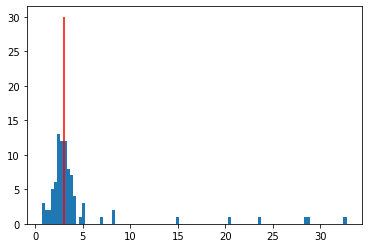

In [20]:
print(tab_obj.columns)
#print(tab_obj['semimajor_axis_sigma'])
plt.hist(tab_obj['semimajor_sigma'].value,bins=100)
print(np.nanmedian(tab_obj['semimajor_sigma'].value))
plt.vlines(np.nanmedian(tab_obj['semimajor_sigma'].value),0,30,color='red')

0.0763091876555071


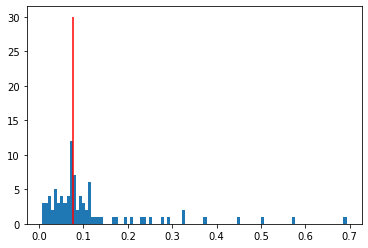

In [21]:
param='ellipticity'
plt.hist(tab_obj[param].value,bins=100)
print(np.nanmedian(tab_obj[param].value))
plt.vlines(np.nanmedian(tab_obj[param].value),0,30,color='red')

In [22]:
#print(tab_obj['label'])
        

In [23]:
sigma_lim = 2.5/pix_rat/2.354

In [24]:
mask_stars = (tab_obj['semimajor_sigma'].value<sigma_lim) & (tab_obj['semiminor_sigma'].value<sigma_lim) & (tab_obj['ellipticity'].value<0.2)
#print(np.nanmedian(tab_obj['semimajor_axis_sigma'].value[mask_stars]))
sigma_img = np.mean(tab_obj['semiminor_sigma'].value[mask_stars])
fwhm_img = 2.354*pix_rat*sigma_img
print(f'FWHM = {fwhm_img} arcsec')
sigma_fwhm = 2.5/pix_rat/2.354
mask_gal = (tab_obj['semimajor_sigma'].value>2*sigma_lim) & (tab_obj['semiminor_sigma'].value>2*sigma_lim) & (tab_obj['ellipticity'].value>0.1)
n_gal=len(tab_obj['semiminor_sigma'][mask_gal])
n_stars=len(tab_obj['semiminor_sigma'][mask_stars])
print(n_stars,n_gal)

FWHM = 1.503599151717097 arcsec
69 6


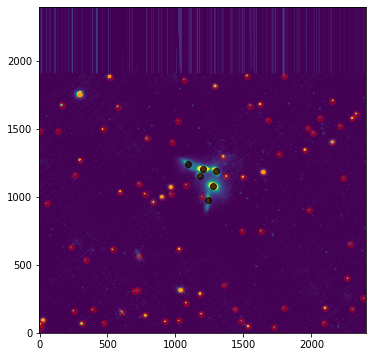

In [25]:
fig,ax = plt.subplots(figsize=(6,6))
#ax[0]=plt.subplot(projection=w)
ax.imshow(hdu[0].data,vmin=-3,vmax=1000,origin='lower')
ax.scatter(tab_obj['xcentroid'],tab_obj['ycentroid'],color='red',edgecolor=None,alpha=0.3)
ax.scatter(tab_obj['xcentroid'][mask_gal],tab_obj['ycentroid'][mask_gal],color='black',edgecolor=None,alpha=0.7)

In [26]:
tab_obj.add_column(np.zeros(len(tab_obj)),name='type')
# 0 uknown
# 1 stars
# 2 galaxies

In [27]:
for tab_now in tab_obj:
    if ((tab_now['semimajor_sigma'].value<sigma_lim) & (tab_now['semiminor_sigma'].value<sigma_lim) &(tab_now['ellipticity'].value<0.2)):
        tab_now['type']=1
    if ((tab_now['semimajor_sigma'].value>2*sigma_lim) & (tab_now['semiminor_sigma'].value>2*sigma_lim) &(tab_now['ellipticity'].value>0.1)):
        tab_now['type']=2

In [28]:
segm_stars = np.zeros((segm.data.shape[1],segm.data.shape[0]))
segm_gal   = segm.data.copy()
for tab_now in tab_obj:
    id_now = tab_now['label']
    type_now = tab_now['type']
    if (tab_now['type']==1):
        segm_stars[segm.data==id_now]=1        
    if (tab_now['type']!=2):
        segm_gal[segm.data==id_now]=0



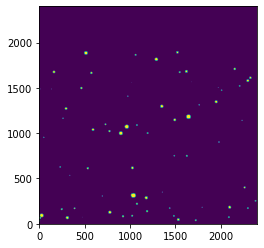

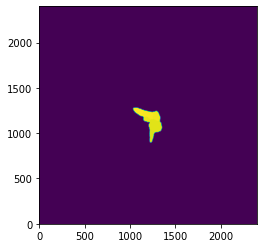

In [29]:
plt.imshow(segm_stars,origin='lower')
plt.show()
plt.imshow(segm_gal,origin='lower')
plt.show()


In [30]:
segm_all = segm.data.copy()
segm_all_org=segm_all.copy()
segm_all[segm_all>0]=1

segm_companions = segm.data.copy()


segm_companions = segm.data.copy()
id_seg_obj = segm_companions[int(position[1]),int(position[0])]
segm_companions[segm_companions==id_seg_obj]=0
segm_companions[segm_companions>0]=1
segm_obj = segm.data.copy()
segm_obj[segm_obj==id_seg_obj]=-1
segm_obj[segm_obj>0]=0
segm_obj=np.abs(segm_obj)

#bkg_est = MedianBackground()
bkg_est = SExtractorBackground()
mask = (segm_all==1)
bkg = Background2D(convolved_data, (15, 15), mask = mask, bkg_estimator=bkg_est)#, filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=bkg_est)
#segm = detect_sources(convolved_data, 30, npixels=5)

In [31]:
print(np.mean(threshold))
print(np.nanmedian(hdu[0].data),np.nanstd(hdu[0].data))

162.82077
1.3859204 1669.898


In [32]:
#print(bkg.background)

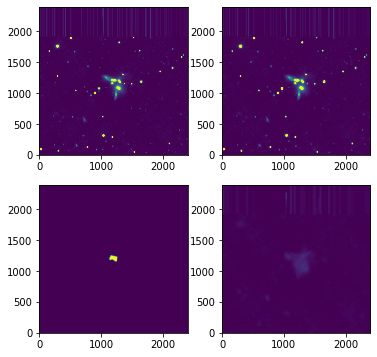

In [33]:


fig,ax = plt.subplots(2,2,figsize=(6,6))
#ax[0]=plt.subplot(projection=w)
ax[0][0].imshow(hdu[0].data,vmin=-3,vmax=1000,origin='lower')
#ax[1]=plt.subplot(projection=w)
ax[0][1].imshow(convolved_data,vmin=-3,vmax=1000,origin='lower')
#ax[1]=plt.subplot(projection=w)
#ax[1].imshow(hdu_center.data,vmin=-3,vmax=10000)

ax[1][0].imshow(segm_obj,origin='lower')
ax[1][1].imshow(bkg.background,vmin=-3,vmax=1000,origin='lower')

masked_data =  ma.array(hdu[0].data,mask=(segm_all==1),fill_value=np.nan)
#print(masked_data.mask)
#x = np.arange(0, masked_data.shape[1])
#y = np.arange(0, masked_data.shape[0])
#xx, yy = np.meshgrid(x, y)
#x1 = xx[~masked_data.mask]
#y1 = yy[~masked_data.mask]
#newarr = masked_data[~masked_data.mask]
#GD1 = interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy),method='cubic')

#primhdu = fits.PrimaryHDU(data=hdu[0].data-bkg.background)
#hdulist=fits.HDUList([primhdu])
#outfile=f'out/{name}.seg.fits.gz'
#hdulist.writeto(outfile,overwrite=True)



In [34]:
print(np.nanmean(bkg.background),np.nanmean(hdu[0].data))

0.3810732215283872 24.417675


In [35]:
cutout= Cutout2D(hdu[0].data-bkg.background, position, size, wcs=w)
cutout_seg_comp= Cutout2D(segm_companions, position, size, wcs=w)
cutout_obj= Cutout2D(segm_obj, position, size, wcs=w)
cutout_segm= Cutout2D(segm, position, size, wcs=w)

#threshold = detect_threshold(masked_data.filled(), nsigma=1)
#print(threshold)

In [36]:
print(cutout.data.shape)

(359, 359)


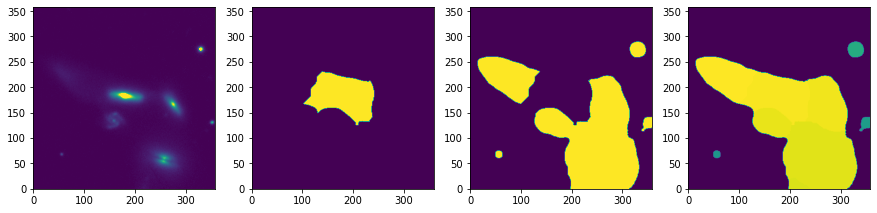

In [37]:
fig,ax = plt.subplots(1,4,figsize=(15,4))
#ax=plt.subplot(projection=wcs.WCS(cutout.wcs.to_header()))
ax[0].imshow(cutout.data,vmin=-3,vmax=10000,origin="lower")
ax[1].imshow(cutout_obj.data,origin="lower")
ax[2].imshow(cutout_seg_comp.data,origin="lower")
ax[3].imshow(cutout_segm.data,origin="lower")


In [38]:
#print(tab_gal.columns)
#tab_sec=Table(results['label'])
#print(tab_ring)

*** remove previous image
83


<ipython-input-12-09ca0c41a7af>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-12-09ca0c41a7af>:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-12-09ca0c41a7af>:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-12-09ca0c41a7af>:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-12-09ca0c41a7af>:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)


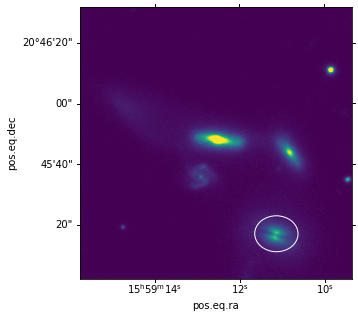

538.5
Aperture: EllipticalAperture
positions: [259.12016303,  59.00114272]
a: 28.602984215681875
b: 23.73412503056652
theta: -0.010133690856379895


/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


520.2852519811472
Max SMA with SN>1 = 520.2852519811472
isolist===<photutils.isophote.isophote.IsophoteList object at 0x7fcb9c672f10>
*** remove previous image


<ipython-input-12-09ca0c41a7af>:45: RuntimeWarning: divide by zero encountered in true_divide
  SN=isolist.intens/err
<ipython-input-6-1d9d64827c25>:229: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-6-1d9d64827c25>:230: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-6-1d9d64827c25>:231: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-6-1d9d64827c25>:232: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-6-1d9d64827c25>:233: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item()

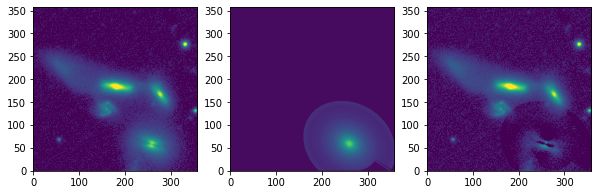

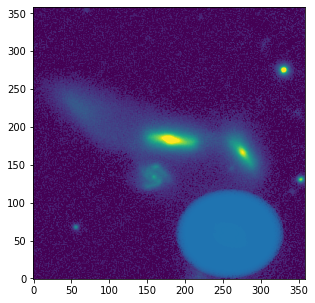

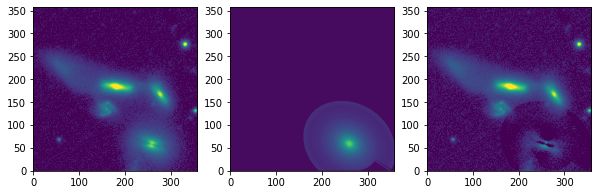

<TableColumns names=('sma','x0','y0','eps','pa','intens')>


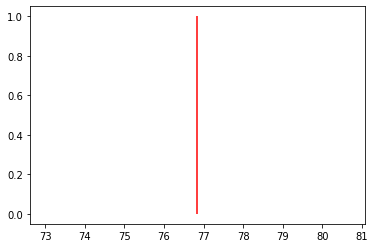

Re_arc, Sb_Re= 19.210960319190836,23.969522796528928
*** iso_ana_super_simple
[83, 76.8438394160372, 19.210960319190836, 259.12016303007476, 59.00114271522534, 0.1702220701309185, -0.5806177169608808]
*** remove previous image
84


<ipython-input-12-09ca0c41a7af>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-12-09ca0c41a7af>:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-12-09ca0c41a7af>:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-12-09ca0c41a7af>:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-12-09ca0c41a7af>:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)


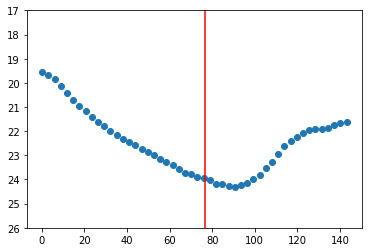

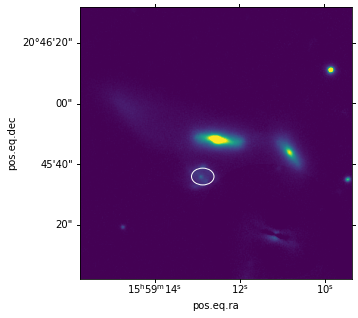

538.5
Aperture: EllipticalAperture
positions: [161.88053496, 134.5838253 ]
a: 14.85717678027567
b: 11.09569717427296
theta: -0.00721894450110891


/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


527.8329517564259
Max SMA with SN>1 = 527.8329517564259
isolist===<photutils.isophote.isophote.IsophoteList object at 0x7fcb9cae6b20>
*** remove previous image


<ipython-input-12-09ca0c41a7af>:45: RuntimeWarning: divide by zero encountered in true_divide
  SN=isolist.intens/err
<ipython-input-6-1d9d64827c25>:229: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-6-1d9d64827c25>:230: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-6-1d9d64827c25>:231: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-6-1d9d64827c25>:232: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-6-1d9d64827c25>:233: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item()

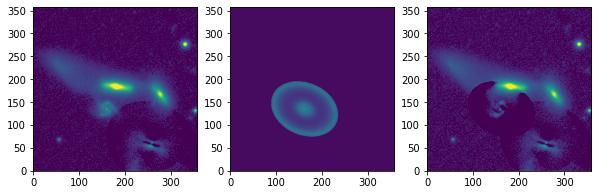

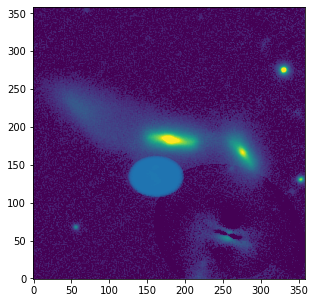

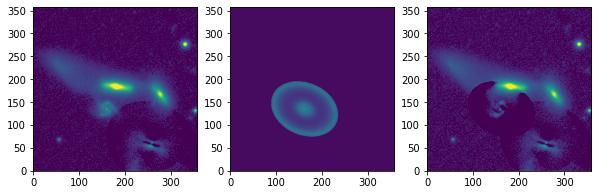

<TableColumns names=('sma','x0','y0','eps','pa','intens')>


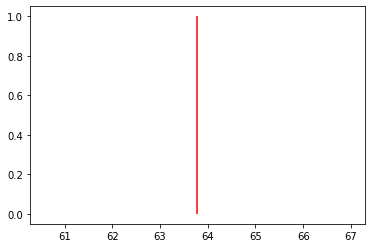

Re_arc, Sb_Re= 15.946353993670902,21.669195226637026
*** iso_ana_super_simple
[84, 63.78541443015917, 15.946353993670902, 161.8805349605061, 134.5838252989547, 0.25317593386897275, -0.4136150524527142]
*** remove previous image
85


<ipython-input-12-09ca0c41a7af>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-12-09ca0c41a7af>:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-12-09ca0c41a7af>:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-12-09ca0c41a7af>:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-12-09ca0c41a7af>:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)


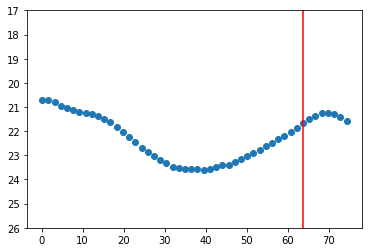

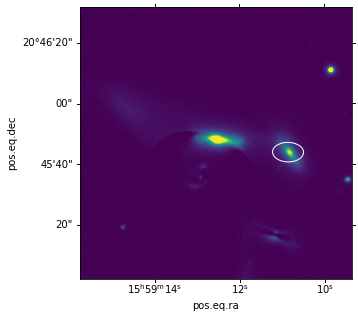

538.5
Aperture: EllipticalAperture
positions: [274.52278322, 166.77341928]
a: 20.454134854708727
b: 12.869562109272113
theta: -0.01948781581020203
465.0731819926642
Max SMA with SN>1 = 62.42106584078591
isolist===<photutils.isophote.isophote.IsophoteList object at 0x7fcb9c263880>
*** remove previous image


<ipython-input-12-09ca0c41a7af>:45: RuntimeWarning: divide by zero encountered in true_divide
  SN=isolist.intens/err
<ipython-input-6-1d9d64827c25>:229: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-6-1d9d64827c25>:230: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-6-1d9d64827c25>:231: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-6-1d9d64827c25>:232: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-6-1d9d64827c25>:233: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item()

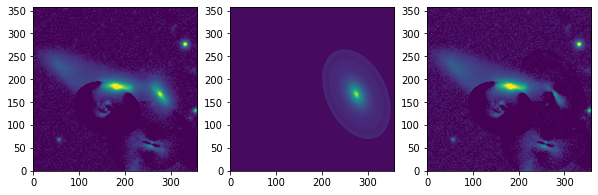

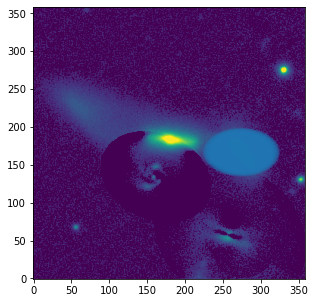

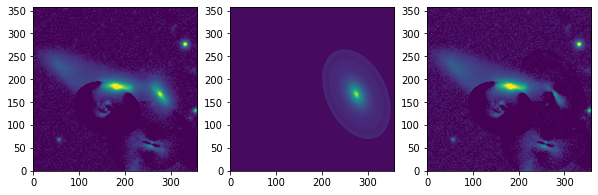

<TableColumns names=('sma','x0','y0','eps','pa','intens')>


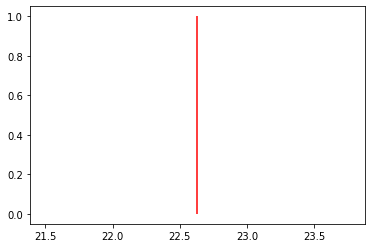

Re_arc, Sb_Re= 5.657737495546278,21.411634735000614
*** iso_ana_super_simple
[85, 22.63094943419064, 5.657737495546278, 274.5227832217756, 166.77341927757584, 0.3708087777513883, -1.1165695978528951]
*** remove previous image
86


<ipython-input-12-09ca0c41a7af>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-12-09ca0c41a7af>:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-12-09ca0c41a7af>:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-12-09ca0c41a7af>:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-12-09ca0c41a7af>:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)


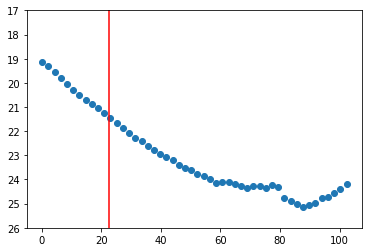

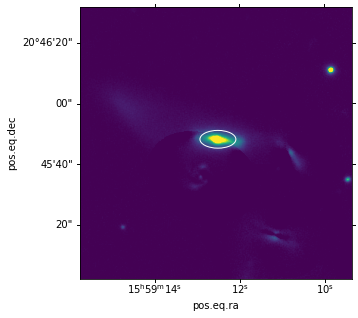

538.5
Aperture: EllipticalAperture
positions: [181.87692014, 183.78376034]
a: 23.74652721679651
b: 11.717824867032535
theta: -0.002683461646550867


/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/sanchez/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


431.9468137836612
Max SMA with SN>1 = 431.9468137836612
isolist===<photutils.isophote.isophote.IsophoteList object at 0x7fcb9268c040>
*** remove previous image


<ipython-input-12-09ca0c41a7af>:45: RuntimeWarning: divide by zero encountered in true_divide
  SN=isolist.intens/err
<ipython-input-6-1d9d64827c25>:229: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-6-1d9d64827c25>:230: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-6-1d9d64827c25>:231: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-6-1d9d64827c25>:232: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-6-1d9d64827c25>:233: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item()

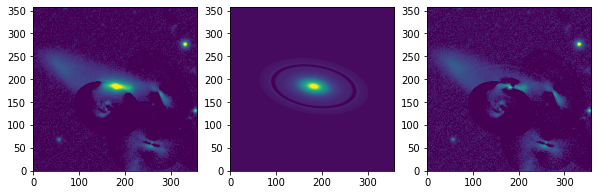

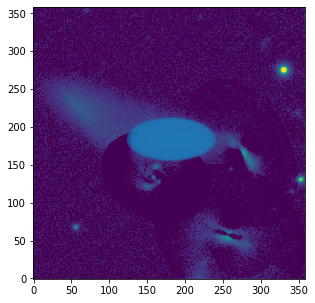

<ipython-input-6-1d9d64827c25>:253: RuntimeWarning: invalid value encountered in log10
  sb_mag=-2.5*np.log10(tab_ring_new['intens']/pix_rat**2)+25+2.5*np.log10(EXPTIME)


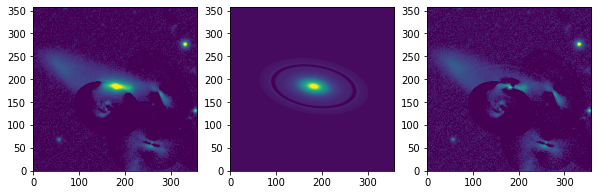

<TableColumns names=('sma','x0','y0','eps','pa','intens')>


<ipython-input-6-1d9d64827c25>:266: RuntimeWarning: invalid value encountered in log10
  tab_ring.add_column(-2.5*np.log10(tab_ring['intens']/pix_rat**2)+25+2.5*np.log10(EXPTIME),name='sb_ring')


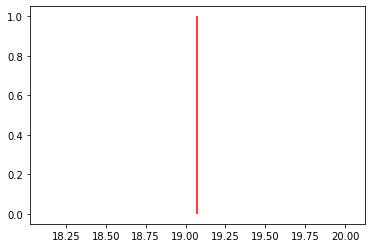

Re_arc, Sb_Re= 4.768692295848512,20.18725307260624
*** iso_ana_super_simple
[86, 19.074768721510296, 4.768692295848512, 181.87692013832066, 183.78376033695736, 0.506545746245193, -0.15375102683259131]
*** remove previous image
87


<ipython-input-12-09ca0c41a7af>:13: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-12-09ca0c41a7af>:14: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-12-09ca0c41a7af>:15: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-12-09ca0c41a7af>:16: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-12-09ca0c41a7af>:17: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)


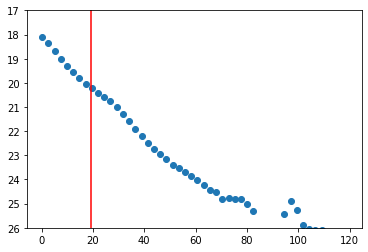

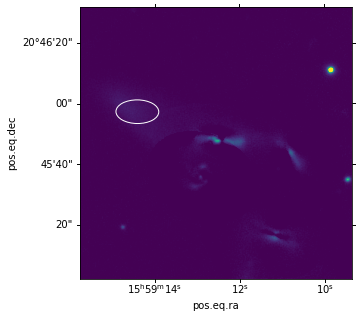

538.5
Aperture: EllipticalAperture
positions: [ 75.49604225, 220.20334388]
a: 28.27374734839129
b: 15.605133593377019
theta: -0.009239457652857315
*** remove previous image


<ipython-input-6-1d9d64827c25>:229: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x0=np.asscalar(1.0*tab_obj['xcentroid'][indx]-(position[0]-0.5*size[0]))
<ipython-input-6-1d9d64827c25>:230: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  y0=np.asscalar(1.0*tab_obj['ycentroid'][indx]-(position[1]-0.5*size[1]))
<ipython-input-6-1d9d64827c25>:231: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  sma=np.asscalar(tab_obj['semimajor_sigma'][indx].value)
<ipython-input-6-1d9d64827c25>:232: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  eps=np.asscalar(1.0*tab_obj['ellipticity'][indx].value)
<ipython-input-6-1d9d64827c25>:233: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  pa=np.asscalar((np.pi/180)*tab_obj['orientation'][indx].value)
<ipython-input-6-1d9d64827c25>:54: Deprecati

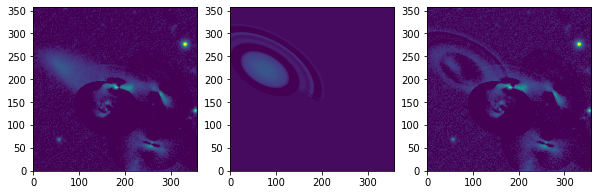

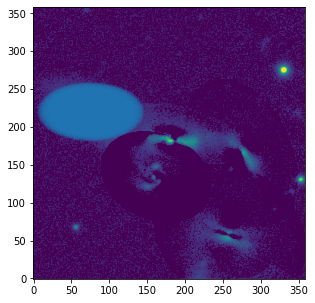

<ipython-input-6-1d9d64827c25>:253: RuntimeWarning: invalid value encountered in log10
  sb_mag=-2.5*np.log10(tab_ring_new['intens']/pix_rat**2)+25+2.5*np.log10(EXPTIME)


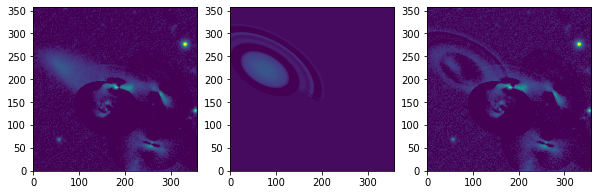

<TableColumns names=('sma','x0','y0','eps','pa','intens')>


<ipython-input-6-1d9d64827c25>:266: RuntimeWarning: invalid value encountered in log10
  tab_ring.add_column(-2.5*np.log10(tab_ring['intens']/pix_rat**2)+25+2.5*np.log10(EXPTIME),name='sb_ring')


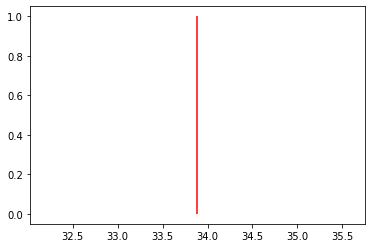

Re_arc, Sb_Re= 8.471899900770275,22.623637863788986
*** iso_ana_super_simple
[87, 33.88759878251381, 8.471899900770275, 75.4960422462882, 220.2033438752885, 0.4480698507668841, -0.5293819284985738]


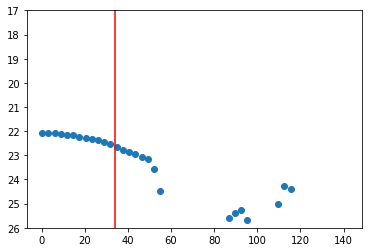

In [39]:
ind_now = 0
plot=1
verbose=1
x0_list=(1.0*tab_obj['xcentroid']-(position[0]-0.5*size[0]))
y0_list=(1.0*tab_obj['ycentroid']-(position[1]-0.5*size[1]))

#print(x0_list,y0_list)

mask_gal = (tab_obj['type']==2) & (x0_list>0) & (x0_list<size[0]) & (y0_list>0) & (y0_list<size[0])

tab_gal = tab_obj[mask_gal]
models=[]
tabs_ring=[]
for tab_gal_now in tab_gal:
    if (ind_now==0):
        model_img = np.zeros((cutout.data.shape[1],cutout.data.shape[0]))
    else:
        model_img = model_img+results['model_img']
    try:
        results=iso_ana(cutout,cutout_segm,tab_gal,ind_now,position,size,\
                               model_img=model_img,plot=plot,verbose=verbose)
        print('*** iso_ana')
    except:
        results=iso_ana_super_simple(cutout,cutout_segm,tab_gal,ind_now,position,size,\
                               model_img=model_img,plot=plot,verbose=verbose)
        print('*** iso_ana_super_simple')
    keys = ['label','Re','Re_arc','xc_iso','yc_iso','eps_iso','pa_iso']
    values = [results.get(key) for key in keys]
    tab_vals=Table(np.array(values),names=keys)
    print(values)
    if (ind_now==0):
        tab_gals_vals=tab_vals
    else:
        tab_gals_vals=vstack_table([tab_gals_vals,tab_vals])
    tab_ring=results['tab_ring']
    tabs_ring.append(tab_ring)
    models.append(results['model_img'])
    ind_now=ind_now+1
#    plt.scatter(tab_ring['sma'],tab_ring['sb_ring'])
#    plt.vlines(results['Re'],ymin=26,ymax=17,color='red')
#    plt.ylim(26,17)
#    plt.show()



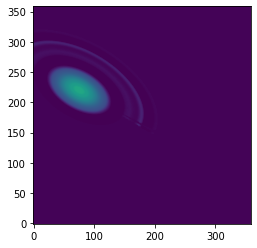

In [40]:
plt.imshow(results['model_img'],vmin=-10,vmax=1000,origin='lower')

In [41]:
tab_obj.remove_column('sky_centroid')

In [42]:
tab_gal=join(tab_gal,tab_gals_vals,keys=['label'],join_type='left')
tab_gal.remove_column('sky_centroid')

In [43]:
#
# Match with new CALIFA cubes
#
hdu_cut=fits.ImageHDU(data=cutout.data,header=cutout.wcs.to_header(),name='CUTOUT')
hdu_seg=fits.ImageHDU(data=cutout_segm.data,header=cutout.wcs.to_header(),name='CUTSEGM')
file_cube=f'{fdir_out}/{name}.V500.drscube.fits.gz'
if (path.exists(file_cube)):
    print(f'{file_cube} exists')
    hdu_cube=fits.open(file_cube)
    (nz_c,ny_c,nx_c)=hdu_cube[0].data.shape
    print(nz_c,ny_c,nx_c)
    w = WCS(hdu_cube[0].header)
    w = w.dropaxis(2)
    h = w.to_header()
    h['NAXIS']=2
    h['NAXIS1']=nx_c
    h['NAXIS2']=ny_c
#    print(h)
    cut_to_CAL, fp_cut_to_CAL = reproject_interp(hdu_cut,h)
    seg_to_CAL, fp_seg_to_CAL = reproject_interp(hdu_seg,h)
    rat = hdu_cube['FLAT'].data/hdu_cube['FLAT'].data
    rat[np.isnan(rat)]=0
    rat[hdu_cube['GAIA_MASK']==1]=0
    cut_to_CAL = cut_to_CAL*rat
    seg_to_CAL = seg_to_CAL*rat
    tab_cen=centroid_segm(cut_to_CAL,seg_to_CAL,tab_gal,h)
#    co = coordinates.SkyCoord(ra=tab_cen['RA'], dec=tab_cen['DEC'], unit=(u.deg, u.deg), frame='icrs')
#    print(co)
#    result_table = Ned.query_region(co, radius=(5/3600)* u.deg, equinox='J2000')
#    print(result_table['Object Name'])

out/NGC6027.V500.drscube.fits.gz exists
1877 150 160


<ipython-input-43-ed6887636d69>:21: RuntimeWarning: invalid value encountered in true_divide
  rat = hdu_cube['FLAT'].data/hdu_cube['FLAT'].data


In [44]:
tab_cen

label,id,xc,yc,RA,DEC
int32,int32,float32,float32,float32,float32
83,0,110.86683,7.0749345,239.79683,20.747345
84,1,61.51015,43.671173,239.80368,20.757511
85,2,119.75912,59.04656,239.7956,20.761782
86,3,72.248276,67.49879,239.80219,20.76413
87,4,18.538353,85.05556,239.80965,20.769007


In [45]:
#plt.imshow(cut_to_CAL,origin='lower')
#plt.scatter(tab_cen['xc'],tab_cen['yc'],color='red',alpha=0.5)
#plt.show()
#plt.imshow(seg_to_CAL,origin='lower')
#plt.scatter(tab_cen['xc'],tab_cen['yc'],color='red',alpha=0.5)
#plt.show()
print(tab_cen)

label  id     xc        yc        RA       DEC   
----- --- --------- --------- --------- ---------
   83   0 110.86683 7.0749345 239.79683 20.747345
   84   1  61.51015 43.671173 239.80368 20.757511
   85   2 119.75912  59.04656  239.7956 20.761782
   86   3 72.248276  67.49879 239.80219  20.76413
   87   4 18.538353  85.05556 239.80965 20.769007


In [46]:
file_out=f'{fdir_out}/{name}.iso.fits.gz'
#primhdu = cutout
hdu[0].header['FWHM']=fwhm_img
hdulist=fits.HDUList(hdu[0])
hdulist.append(fits.ImageHDU(data=segm_all_org.data,header=hdu[0].header,name='SEGM'))
hdu_tmp=pyfits.table_to_hdu(tab_obj)
hdu_tmp.name='TAB_OBJ'
hdulist.append(hdu_tmp)
hdulist.append(hdu_cut)
hdulist.append(hdu_seg)
#hdulist.append(fits.ImageHDU(data=cutout.data,header=cutout.wcs.to_header(),name='CUTOUT'))
#hdulist.append(fits.ImageHDU(data=cutout_segm.data,header=cutout.wcs.to_header(),name='CUTSEGM'))
hdu_tmp=pyfits.table_to_hdu(tab_gal)
hdu_tmp.name='TAB_GAL'
hdulist.append(hdu_tmp)
for indx in arange(0,len(tab_gal)):
    tab_ring=tabs_ring[indx]
    model_ring=models[indx]
    hdu_tmp=pyfits.table_to_hdu(tab_ring)
    hdu_tmp.name=f'TAB_ISO_{indx}'
    hdulist.append(hdu_tmp)
    hdulist.append(fits.ImageHDU(data=model_ring,header=cutout.wcs.to_header(),name=f'MODEL_{indx}'))

if (path.exists(file_cube)):
    hdulist.append(fits.ImageHDU(data=cut_to_CAL,header=h,name='PS_CAL'))
    hdulist.append(fits.ImageHDU(data=seg_to_CAL,header=h,name='SEG_CAL'))
    hdu_tmp=pyfits.table_to_hdu(tab_cen)
    hdu_tmp.name=f'TAB_CEN'
    hdulist.append(hdu_tmp)
print(hdulist.info())
hdulist.writeto(file_out,overwrite=True)

#
# Add the tables and write the output!!! 
#

#ax=plt.subplot(projection=wcs.WCS(cutout.wcs.to_header()))

#print(cutout.h)

#hdulist.append(fits.ImageHDU(data=cube_err,name='ERROR'))


Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     193   (2400, 2400)   float32   
  1  SEGM          1 ImageHDU       195   (2400, 2400)   int64   
  2  TAB_OBJ       1 BinTableHDU     58   87R x 21C   ['K', 'D', 'D', 'K', 'K', 'K', 'K', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']   
  3  CUTOUT        1 ImageHDU        28   (359, 359)   float64   
  4  CUTSEGM       1 ImageHDU        28   (359, 359)   int64   
  5  TAB_GAL       1 BinTableHDU     70   5R x 27C   ['D', 'D', 'D', 'K', 'K', 'K', 'K', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']   
  6  TAB_ISO_0     1 BinTableHDU     23   50R x 7C   ['D', 'D', 'D', 'D', 'D', 'D', 'D']   
  7  MODEL_0       1 ImageHDU        28   (359, 359)   float64   
  8  TAB_ISO_1     1 BinTableHDU     23   50R x 7C   ['D', 'D', 'D', 'D', 'D', 'D', 'D']   
  9  MODEL_1       1

In [47]:
tab_cen
h

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =                 73.0 / Pixel coordinate of reference point            
CRPIX2  =                 63.0 / Pixel coordinate of reference point            
PC1_1   = -0.00013888888888888 / Coordinate transformation matrix element       
PC2_2   =  0.00013888888888889 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =      239.80222131514 / [deg] Coordinate value at reference point      
CRVAL2  =       20.762602385

In [48]:
#print(tab_gals_vals)

In [49]:
#tab_gal=join(tab_gal,tab_gals_vals,keys=['label'],join_type='left')

In [50]:
#print(tab_gal.columns)

In [51]:
#plt.imshow(models[0],origin='lower')

In [52]:
#tab_ring=results['tab_ring']
#print(tab_ring.columns)

In [53]:
#tab_ring=tabs_ring[1]
#plt.scatter(tab_ring['sma'],tab_ring['sb_ring'])
#plt.vlines(results['Re'],ymin=26,ymax=17,color='red')
#plt.ylim(26,17)
#plt.show()

In [54]:
#tab_gal = tab_obj[tab_obj['type']==2]
#print(tab_gal)
#results=iso_ana(cutout,segm,tab_gal,0,position,size)
#model_img_0 = results['model_img']


In [55]:
#print(results)

In [ ]:
#iso_ana(cutout,segm,tab_gal,1,position,size,model_img=model_img_0)